In [1]:
import numpy as np
import symengine as spe
import matplotlib.pyplot as plt
import csv
import sympy
import copy
import torch
from scipy.optimize import minimize, fsolve
import nonlinear_benchmarks
from nonlinear_benchmarks.error_metrics import RMSE
from scipy.signal import savgol_filter
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import time
import csv
import pickle
t = spe.symbols('t')
exec(open("../GODE/scipy_solver.py").read())
exec(open("../GODE/loss_function.py").read())

In [2]:
# Load Silverbox Benchmark
train, test = nonlinear_benchmarks.Silverbox()
test_multisine, test_arrow_full, test_arrow_no_extrapolation = test
print('Training datasize: ', train.y.shape[0])
print('Test total', test_multisine.y.shape[0]+test_arrow_full.y.shape[0])

Training datasize:  65062
Test total 62163


In [3]:
# Load solutions
best_gvae_eq = ''
best_proged_eq = ''
best_pysr_eq = ''
# GVAE result
curr_loss = 1e6
curr_eq = ''
with open('GODE_results/Output_silver_box_GODE.csv', mode = 'r') as csvfile:
    csv_read = csv.reader(csvfile)
    k = 0
    for row in csv_read:
        if k == 0:
            k += 1
            continue
        _, eq, loss = row
        if float(loss) < curr_loss:
            curr_eq = eq
            curr_loss = float(loss)
        if k == 4: # second best score
            best_gvae2_eq = eq
        k += 1
best_gvae_eq = curr_eq
# ProGED 
curr_loss = 1e6
curr_eq = ''
with open('Others_results/ProGED/Output_ProGED_silver_box_best.csv', mode = 'r') as csvfile:
    csv_read = csv.reader(csvfile)
    k = 0
    for row in csv_read:
        if k == 0:
            k += 1
            continue
        eq, loss = row
        eqs = eq.split(',')
        if float(loss) < curr_loss:
            curr_eq = eqs[3][:-1].replace('x0', 'u').replace('x1', 'diff(u,t)').replace('x2', 'diff(diff(u,t),t)')
            curr_loss = float(loss)
        k += 1
best_proged_eq = curr_eq
# PySR
curr_loss = 1e6
curr_eq = ''
with open('Others_results/PySR/Output_PySR_silverbox_best.csv', mode = 'r') as csvfile:
    csv_read = csv.reader(csvfile)
    k = 0
    for row in csv_read:
        if k == 0:
            k += 1
            continue
        eq, loss = row
        if float(loss) < curr_loss:
            curr_eq = eq.replace('x3', 'diff(diff(u,t),t)')
            curr_loss = float(loss)
        k += 1
best_pysr_eq = curr_eq

In [4]:
models = ['gvae', 'gvae2', 'proged', 'pysr']
for m in models:
    print('Best equation of', m, ':', locals()[f"best_{m}_eq"])

Best equation of gvae : 0.00027866519926823607*diff(u,t)+2.033126580115953*u+2.7611436653310584*u*u*u+1.0449007168562921e-05*diff(diff(u,t),t)
Best equation of gvae2 : 7.759178231491104e-06*diff(diff(u,t),t)+1.2161250811242201*diff(u,t)*u*u+1.5514367563485256*u
Best equation of proged :  diff(diff(u,t),t)
Best equation of pysr : ((0.12089262 * (diff(u,t) + (0.072878644 * (0.066155486 * diff(diff(u,t),t))))) * 0.00906198) - (-0.0051649073 - u)


In [5]:
# preprocess data
fs = 1/train.sampling_time
ORDER = 2
n_data = 1500
t_low = 0.

print('Sampling frequency:', fs)
t_high = (n_data-2)*train.sampling_time
t_val = np.linspace(*(t_low, t_high), int((t_high-t_low)*fs)) #+1/fs
u_val = train.y[1:n_data]
f_val = torch.from_numpy(train.u[1:n_data])
window_size = 4
poly_order = 3
# Data preprocessing for velocity and acceleration
du_val = savgol_filter(train.y[1:n_data], window_size, poly_order, deriv=1, delta=train.sampling_time)
d2u_val = savgol_filter(train.y[1:n_data], window_size, poly_order, deriv=2, delta=train.sampling_time)
y0 = [train.y[1], du_val[0]]
data_train = np.vstack((u_val, du_val, d2u_val)).T
print('Train y0: ',y0)
print('Multi-sine')
n_MS = test_multisine.state_initialization_window_length
f_test_val_MS = test_multisine.u
u_test_val_MS = savgol_filter(test_multisine.y, window_size, poly_order, deriv=0, delta=train.sampling_time)
du_test_val_MS = savgol_filter(test_multisine.y, window_size, poly_order, deriv=1, delta=train.sampling_time)
#d2u_test_val_MS = savgol_filter(test_multisine.y, window_size, poly_order, deriv=2, delta=train.sampling_time)
t_high_test_MS = test_multisine.y.shape[0]*train.sampling_time
t_val_test_MS = np.linspace(*(t_low, t_high_test_MS), int((t_high_test_MS-t_low)*fs))
y0_test_MS = [test_multisine.y[0],du_test_val_MS[0]]
print('Test y0: ', y0_test_MS)
#data_test_MS = np.vstack((u_test_val_MS, du_test_val_MS, d2u_test_val_MS)).T
print('Arrow full')
n_AF = test_arrow_full.state_initialization_window_length
f_test_val_AF = test_arrow_full.u
u_test_val_AF = savgol_filter(test_arrow_full.y, window_size, poly_order, deriv=0, delta=train.sampling_time)
du_test_val_AF = savgol_filter(test_arrow_full.y, window_size, poly_order, deriv=1, delta=train.sampling_time)
#d2u_test_val_AF = savgol_filter(test_arrow_full.y, window_size, poly_order, deriv=2, delta=train.sampling_time)
t_high_test_AF = test_arrow_full.y.shape[0]*train.sampling_time
t_val_test_AF = np.linspace(*(t_low, t_high_test_AF), int((t_high_test_AF-t_low)*fs))
y0_test_AF = [test_arrow_full.y[0],du_test_val_AF[0]]
print('Test y0: ', y0_test_AF)
#data_test_AF = np.vstack((u_test_val_AF, du_test_val_AF, d2u_test_val_AF)).T
print('Arrow no extrapolation')
n_ANE = test_arrow_no_extrapolation.state_initialization_window_length
f_test_val_ANE = test_arrow_no_extrapolation.u
u_test_val_ANE = savgol_filter(test_arrow_no_extrapolation.y, window_size, poly_order, deriv=0, delta=train.sampling_time)
du_test_val_ANE = savgol_filter(test_arrow_no_extrapolation.y, window_size, poly_order, deriv=1, delta=train.sampling_time)
#d2u_test_val_ANE = savgol_filter(test_arrow_no_extrapolation.y, window_size, poly_order, deriv=2, delta=train.sampling_time)
t_high_test_ANE = test_arrow_no_extrapolation.y.shape[0]*train.sampling_time
t_val_test_ANE = np.linspace(*(t_low, t_high_test_ANE), int((t_high_test_ANE-t_low)*fs))
y0_test_ANE = [test_arrow_full.y[0],du_test_val_ANE[0]]
print('Test y0: ', y0_test_ANE)
#data_test_ANE = np.vstack((u_test_val_ANE, du_test_val_ANE, d2u_test_val_ANE)).T

Sampling frequency: 610.35
Train y0:  [-0.04009358560023829, -47.85525685711705]
Multi-sine
Test y0:  [0.028760261952673317, 15.69286331550924]
Arrow full
Test y0:  [0.0008587612469447777, 0.6939502366901298]
Arrow no extrapolation
Test y0:  [0.0008587612469447777, 0.6939502366901298]


In [6]:
# Evaluate test metric
labels = ['_MS', '_AF', '_ANE']
RMSE_scores = dict()
for m in models:
    RMSE_scores[m] = dict()

In [7]:
# TODO: Increase with_timeout of solve_implicit_ode to 180
for label in labels:
    for m in models:
        print('Model:', m, 'Test:', label)
        time_start = time.time()
        sol = solve_implicit_ode(locals()[f"best_{m}_eq"], t_low, locals()[f"t_high_test{label}"]-1/fs, fs = fs, y0 = locals()[f"y0_test{label}"], order = ORDER, CHECK_SUCCESS = True, force = locals()[f"f_test_val{label}"])
        time_end = time.time()
        print('Time taken to solve ODE:', time_end - time_start, 'seconds')
        RMSE_scores[m][label] = 1000*RMSE(locals()[f"u_test_val{label}"][locals()[f"n{label}"]:], sol[1][locals()[f"n{label}"]:])
        print('RMSE Score:', RMSE_scores[m][label], 'mV')

Model: gvae Test: _MS
Time taken to solve ODE: 17.275396823883057 seconds
RMSE Score: 24.887076720079506 mV
Model: gvae2 Test: _MS
Time taken to solve ODE: 19.287590980529785 seconds
RMSE Score: 33.14063573266309 mV
Model: proged Test: _MS
Time taken to solve ODE: 1.1485528945922852 seconds
RMSE Score: 323897.086933459 mV
Model: pysr Test: _MS
Time taken to solve ODE: 18.136950969696045 seconds
RMSE Score: 40.826238466343675 mV
Model: gvae Test: _AF
Time taken to solve ODE: 35.392773151397705 seconds
RMSE Score: 26.607913699776905 mV
Model: gvae2 Test: _AF
Time taken to solve ODE: 39.66807007789612 seconds
RMSE Score: 35.890689273922035 mV
Model: proged Test: _AF
Time taken to solve ODE: 2.494684934616089 seconds
RMSE Score: 32960.863249660644 mV
Model: pysr Test: _AF
Time taken to solve ODE: 38.00432991981506 seconds
RMSE Score: 40.57132757609949 mV
Model: gvae Test: _ANE
Time taken to solve ODE: 24.097836017608643 seconds
RMSE Score: 20.029766497070977 mV
Model: gvae2 Test: _ANE
Time

In [7]:
#with open('RMSE_Test_Silverbox_discovered.pkl', 'wb') as f:
#    pickle.dump(RMSE_scores, f)

In [7]:
with open('RMSE_Test_Silverbox_discovered.pkl', 'rb') as f:
    RMSE_scores = pickle.load(f)
RMSE_scores

{'gvae': {'_MS': 24.913649690008278,
  '_AF': 26.630945343441475,
  '_ANE': 20.047003180575256},
 'gvae2': {'_MS': 33.14186308638964,
  '_AF': 35.88417575058989,
  '_ANE': 26.364295734622722},
 'proged': {'_MS': 324085.51613435434,
  '_AF': 32596.979992845496,
  '_ANE': 24781.117446292017},
 'pysr': {'_MS': 40.839674649152556,
  '_AF': 40.58227104986664,
  '_ANE': 32.43120838902911}}

In [8]:
# Optimizing the constants
models_post_processing = ['gvae', 'gvae2', 'pysr']
skeleton_exprs = dict()
skeleton_exprs['pysr'] = 'C*diff(diff(u,t),t)+C*diff(u,t)+C*u+C'
skeleton_exprs['gvae'] = 'C*diff(diff(u,t),t)+C*diff(u,t)+C*u+C*u**3'
skeleton_exprs['gvae2'] = 'C*diff(diff(u,t),t)+C*diff(u,t)*u**2+C*u'
constants_initial = dict()
# ((0.12089262 * (diff(u,t) + (0.072878644 * (0.066155486 * diff(diff(u,t),t))))) * 0.00906198) - (-0.0051649073 - u)
# = 0.0051649073 + u + 0.0010955265045876*diff(u, t) + 5.28188616177159e-06*diff(diff(u, t), t)
constants_initial['pysr'] = [5.28188616177159e-06, 0.0010955265045876, 1, 0.0051649073]
# 0.00027866519926823607*diff(u,t)+2.033126580115953*u+2.7611436653310584*u*u*u+1.0449007168562921e-05*diff(diff(u,t),t)
constants_initial['gvae'] = [1.0449007168562921e-05, 0.00027866519926823607, 2.033126580115953, 2.7611436653310584]
# 7.759178231491104e-06*diff(diff(u,t),t)+1.2161250811242201*diff(u,t)*u*u+1.5514367563485256*u
constants_initial['gvae2'] = [7.759178231491104e-06, 1.2161250811242201, 1.5514367563485256]
post_processed_eqs = dict()

In [9]:
def find_C_values(C, skeleton_expr_eq, ORDER):
    C_torch = torch.from_numpy(C).unsqueeze(0)
    eq = replace_C_with_values(skeleton_expr_eq, C_torch)
    try:
        more_accurate_loss = solve_smse_DE(eq, data_train, t_val, order=ORDER, y0=y0,force = f_val) 
        if more_accurate_loss == np.nan or more_accurate_loss == np.inf or more_accurate_loss == -np.inf:
            return 1e10
        if more_accurate_loss < 10.:
            print('Eq: ', eq, 'loss: ', more_accurate_loss)
        return more_accurate_loss
    except:
        return 1e10
    return loss

def optimize_constants(skeleton_expr_eq, ORDER, C_initial): #,
    find_C = lambda C: find_C_values(C, skeleton_expr_eq, ORDER)
    C_optim = minimize(find_C, C_initial, method = 'Nelder-Mead',options={'fatol': 1e-3, 'maxiter': 1000}) #increased from 500 to 1000
    return C_optim.x

In [ ]:
# INCREASE TIME WRAPPER TO 10s!
for m in models_post_processing:
    print('Model:', m)
    time_start = time.time()
    C_optimal = optimize_constants(skeleton_exprs[m], ORDER, np.array(constants_initial[m]))
    time_end = time.time()
    print('Time taken to solve ODE:', time_end - time_start, 'seconds')
    post_processed_eqs[m] = replace_C_with_values(skeleton_exprs[m], torch.from_numpy(C_optimal).unsqueeze(0))
    print('Discovered equation:', post_processed_eqs[m])

Model: gvae
Eq:  1.0449007168562921e-05*diff(diff(u,t),t)+0.00027866519926823607*diff(u,t)+2.033126580115953*u+2.7611436653310584*u**3 loss:  0.6546897509505557
Eq:  1.0971457526991068e-05*diff(diff(u,t),t)+0.00027866519926823607*diff(u,t)+2.033126580115953*u+2.7611436653310584*u**3 loss:  0.9348798506269127
Eq:  1.0449007168562921e-05*diff(diff(u,t),t)+0.00029259845923164786*diff(u,t)+2.033126580115953*u+2.7611436653310584*u**3 loss:  0.6567355287399358
Eq:  1.0449007168562921e-05*diff(diff(u,t),t)+0.00027866519926823607*diff(u,t)+2.1347829091217507*u+2.7611436653310584*u**3 loss:  0.981068345999875
Eq:  1.0449007168562921e-05*diff(diff(u,t),t)+0.00027866519926823607*diff(u,t)+2.033126580115953*u+2.8992008485976113*u**3 loss:  0.6535813124143737
Eq:  1.0514313463366439e-05*diff(diff(u,t),t)+0.00028040685676366254*diff(u,t)+2.0839547446188518*u+2.7784008132393776*u**3 loss:  0.722325459920246
Eq:  1.0718395634627434e-05*diff(diff(u,t),t)+0.00028062456395059086*diff(u,t)+2.0394801006788

In [10]:
#with open('Silverbox_postprocessed_eq.pkl', 'wb') as f:
#    pickle.dump(post_processed_eqs, f)

In [10]:
# Evaluate test metric
labels = ['_MS', '_AF', '_ANE']
RMSE_scores_pp = dict()
for m in models_post_processing:
    RMSE_scores_pp[m] = dict()

In [11]:
for label in labels:
    for m in models_post_processing:
        print('Model:', m, 'Test:', label)
        time_start = time.time()
        sol = solve_implicit_ode(post_processed_eqs[m], t_low, locals()[f"t_high_test{label}"]-1/fs, fs = fs, y0 = locals()[f"y0_test{label}"], order = ORDER, CHECK_SUCCESS = True, force = locals()[f"f_test_val{label}"])
        time_end = time.time()
        print('Time taken to solve ODE:', time_end - time_start, 'seconds')
        RMSE_scores_pp[m][label] = 1000*RMSE(locals()[f"u_test_val{label}"][locals()[f"n{label}"]:], sol[1][locals()[f"n{label}"]:])
        print('RMSE Score:', RMSE_scores_pp[m][label], 'mV')

Model: gvae Test: _MS


KeyError: 'gvae'

In [14]:
with open('RMSE_Test_Silverbox_postprocessed.pkl', 'rb') as f:
    RMSE_scores_pp = pickle.load(f)
RMSE_scores_pp
#with open('RMSE_Test_Silverbox_postprocessed.pkl', 'wb') as f:
#    pickle.dump(RMSE_scores_pp, f)

{'gvae': {'_MS': 15.18254228197724,
  '_AF': 15.120267022960796,
  '_ANE': 12.504189731036146},
 'gvae2': {'_MS': 19.94134757764532,
  '_AF': 25.857452462282012,
  '_ANE': 19.277596958621796},
 'pysr': {'_MS': 15.478873922594415,
  '_AF': 20.108793562049833,
  '_ANE': 12.69374625363537}}

In [17]:
with open('Silverbox_postprocessed_eq.pkl', 'rb') as f:
    post_processed_eqs = pickle.load(f)

In [18]:
# takes about 5 min to solve
models_post_processing = ['gvae', 'gvae2', 'pysr']
SOL = dict()
for m in models_post_processing:
    print('Model:', m, 'Test arrow full')
    time_start = time.time()
    sol = solve_implicit_ode(post_processed_eqs[m], t_low, t_high_test_AF-1/fs, fs = fs, y0 = y0_test_AF, order = ORDER, CHECK_SUCCESS = True, force = f_test_val_AF)
    time_end = time.time()
    print('Time taken to solve ODE:', time_end - time_start, 'seconds')
    SOL[m] = sol
    print('RMSE Score:',1000*RMSE(u_test_val_AF[n_AF:], sol[1][n_AF:]), 'mV')

Model: gvae Test arrow full
Time taken to solve ODE: 37.61110305786133 seconds
RMSE Score: 15.07897810639843 mV
Model: gvae2 Test arrow full
Time taken to solve ODE: 37.25593590736389 seconds
RMSE Score: 25.9491254857668 mV
Model: pysr Test arrow full
Time taken to solve ODE: 37.33908677101135 seconds
RMSE Score: 20.090630838729435 mV


In [15]:
import matplotlib as mpl
mpl.rc('font', family = 'Times')
mpl.rcParams['mathtext.fontset'] = 'stix'

KeyError: 'gvae'

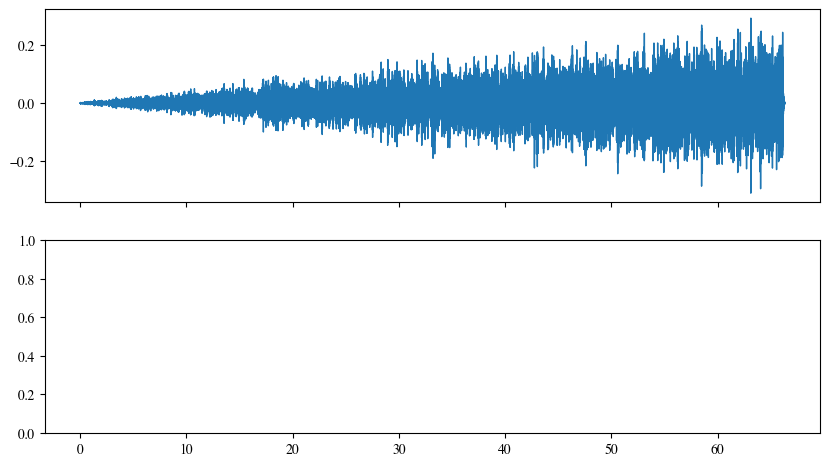

In [16]:
t_val_test = np.linspace(*(t_low, t_high_test_AF), int((t_high_test_AF - t_low+1/fs) * fs))
t_start, t_end = 12.5,13
fig, axs = plt.subplots(2,1, figsize=(10,5.5), sharex= True)
axs[0].plot(t_val_test, u_test_val_AF, color='tab:blue', linewidth = 1, label = 'true')
axs[0].plot(t_val_test, SOL['gvae'][1], '--', color = 'tab:orange',  label = 'GODE (I)')
#axs[0].plot(t_val_test, SOL['gvae2'][1], '-.', color = 'tab:pink',  label = 'GODE (II)')
axs[0].plot(t_val_test, SOL['pysr'][1], ':', color = 'tab:green', label = 'PySR')
axs[0].set_ylim([min(u_test_val_AF[int(t_start*fs):int(t_end*fs)])*1.2, max(u_test_val_AF[int(t_start*fs):int(t_end*fs)])*1.2])
axs[0].set_ylabel(r'$u_t$')
axs[1].plot(t_val_test, du_test_val_AF, color='tab:blue', linewidth = 1, label = '__nolegend__')
axs[1].plot(t_val_test, SOL['gvae'][2], '--', color = 'tab:orange',  label = '__nolegend__')
#axs[1].plot(t_val_test, SOL['gvae2'][2], '-.', color = 'tab:pink',  label = '__nolegend__')
axs[1].plot(t_val_test, SOL['pysr'][2], ':', color = 'tab:green', label ='__nolegend__')
axs[1].set_ylim([min(du_test_val_AF[int(t_start*fs):int(t_end*fs)])*1.2, max(du_test_val_AF[int(t_start*fs):int(t_end*fs)])*1.2])
axs[1].set_ylabel(r'$\dot{u}_t$')
#axs[1].legend(loc = 'lower center', ncol = 4)
fig.legend(loc = 'lower center', ncol = 4, fontsize = 10, bbox_to_anchor=(0.5, -0.03))
plt.xlim([t_start,t_end])
plt.subplots_adjust(hspace=0.07)
plt.xlabel(r'$t$')
plt.savefig('B4_Results.png', dpi = 600, bbox_inches = 'tight')

In [77]:
# Removing shift
1000*RMSE(u_test_val_AF[n_AF:], SOL['gvae'][1][n_AF:]-np.mean(SOL['gvae'][1][n_AF:]))

14.406258993162131